## Example 2: Sensitivity analysis for a NetLogo model with SALib and ipyparallel

This provides a more advanced example of interaction between NetLogo and a Python environment, using the SALib library (Herman & Usher, 2017; available through the pip package manager) to sample and analyze a suitable experimental design for a Sobol global sensitivity analysis. Furthermore, the ipyparallel package (also available on pip) is used to parallelize the simulations.

All files used in the example are available from the pyNetLogo repository at https://github.com/quaquel/pyNetLogo.

In [1]:
#Ensuring compliance of code with both python2 and python3

from __future__ import division, print_function
try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import jpype
import pyNetLogo.pyNetLogo

#Import the sampling and analysis modules for a Sobol variance-based 
#sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

SALib relies on a problem definition dictionary which contains the number of input parameters to sample, their names (which should here correspond to a NetLogo global variable), and the sampling bounds. Documentation for SALib can be found at https://salib.readthedocs.io/en/latest/.

In [5]:
problem = { 
  'num_vars': 6,
  'names': ['random-seed',
            'grass-regrowth-time',
            'sheep-gain-from-food',
            'wolf-gain-from-food',
            'sheep-reproduce',
            'wolf-reproduce'], 
  'bounds': [[1, 100000],
             [20., 40.], 
             [2., 8.], 
             [16., 32.],
             [2., 8.],
             [2., 8.]]
}

The SALib sampler will automatically generate an appropriate number of samples for Sobol analysis, using a revised Saltelli sampling sequence. To calculate first-order, second-order and total sensitivity indices, this gives a sample size of _n(2p+2)_, where _p_ is the number of input parameters, and _n_ is a baseline sample size which should be large enough to stabilize the estimation of the indices. For this example, we use _n_ = 1000, for a total of 14000 experiments.

In [4]:
n = 1000
param_values = saltelli.sample(problem, n, calc_second_order=True)

The sampler generates an input array of shape (_n(2p+2)_, _p_) with rows for each experiment and columns for each input parameter.

In [5]:
param_values.shape

(14000, 6)

### Running the experiments in parallel using ipyparallel

Ipyparallel is a standalone package (available through the pip package manager) which can be used to interactively run parallel tasks from IPython on a single PC, but also on multiple computers. On machines with multiple cores, this can significantly improve performance: for instance, the multiple simulations required for a sensitivity analysis are easy to run in parallel. Documentation for Ipyparallel is available at http://ipyparallel.readthedocs.io/en/latest/intro.html.

Ipyparallel first requires starting a controller and multiple engines, which can be done from a terminal or command prompt with the following:

`ipcluster start -n 4` 

The optional -n argument specifies the number of processes to start (4 in this case).

Next, we can connect the interactive notebook to the started cluster by instantiating a client, and checking that client.ids returns a list of 4 available engines.

In [6]:
import ipyparallel

client = ipyparallel.Client()
client.ids

[0, 1, 2, 3]

We then set up the engines so that they can run the simulations, using a "direct view" that accesses all engines.

We first need to change the working directories to import pyNetLogo on the engines (assuming the pyNetLogo module is located in the same directory as this notebook, rather than being on the Python path). This also ensures we have the proper path to the file we need to load. We also send the SALib problem definition variable to the workspace of the engines, so that it can be used in the simulation.

Note: there are various solutions to both problems. For example, we could make the NetLogo file a keyword argument and pass the absolute path to it. 

In [7]:
direct_view = client[:]

In [8]:
import os

#Push the current working directory of the notebook to a "cwd" variable on the engines that can be accessed later
direct_view.push(dict(cwd=os.getcwd()))

<AsyncResult: _push>

In [9]:
#Push the "problem" variable from the notebook to a corresponding variable on the engines
direct_view.push(dict(problem=problem))

<AsyncResult: _push>

The `%%px` command can be added to a notebook cell to run it in parallel on each of the engines. Here the code first involves some imports and a change of the working directory. We then start a link to NetLogo, and load the example model on each of the engines.


In [10]:
%%px 

import os
os.chdir(cwd)

import jpype
import pyNetLogo.pyNetLogo
import pandas as pd
import numpy as np

netlogo = pyNetLogo.pyNetLogo.NetLogoLink(gui=False)
netlogo.load_model(r'Wolf Sheep Predation_v6.nlogo')

We can then use the IPyparallel map functionality to run the sampled experiments, now using a "load balanced" view to automatically handle the scheduling and distribution of the simulations across the engines. This is for instance useful when simulations may take different amounts of time.

We first set up a simulation function that takes a single experiment (i.e. a vector of input parameters) as an argument, and returns the outcomes of interest in a pandas Series.

In [12]:
def simulation(experiment):
    
    #Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            #The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(experiment[i]))
        else:
            #Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, experiment[i]))

    netlogo.command('setup')
    #Run for 100 ticks and return the number of sheep and wolf agents at each time step
    counts = netlogo.repeat_report(['count sheep','count wolves'], 100)    
    
    results = pd.Series([counts['count sheep'].values.mean(), 
                         counts['count wolves'].values.mean()], 
                         index=['Avg. sheep', 'Avg. wolves'])
    
    return results

We then create a load balanced view and run the simulation with the `map_sync` method. This method takes a function and a Python sequence as arguments, applies the function to each element of the sequence, and returns results once all computations are finished.

In this case, we pass the simulation function and the array of experiments (param_values), so that the function will be executed for each row of the array.

The DataFrame constructor is then used to immediately build a DataFrame from the results (which are returned as a list of Series). The `to_csv` method provides a simple way of saving the results to disk; pandas supports several more advanced storage options, such as serialization with msgpack, or hierarchical HDF5 storage.

In [ ]:
lview = client.load_balanced_view()

results = pd.DataFrame(lview.map_sync(simulation, param_values))

In [ ]:
results.to_csv('Sobol_parallel.csv')

In [7]:
results.head(5)

,Avg. sheep,Avg. wolves
0,125.25,91.52
1,136.85,110.37
2,125.98,84.50
3,136.46,106.76
4,284.34,55.39


### Using SALib for sensitivity analysis

We can then proceed with the analysis, first using a histogram to visualize output distributions for each outcome:

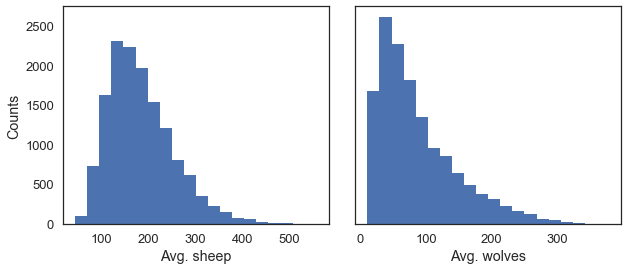

In [8]:
fig, ax = plt.subplots(1,len(results.columns), sharey=True)

for i, n in enumerate(results.columns):
    ax[i].hist(results[n], 20)
    ax[i].set_xlabel(n)
ax[0].set_ylabel('Counts')

fig.set_size_inches(10,4)
fig.subplots_adjust(wspace=0.1)

plt.show()

Bivariate scatter plots can be useful to visualize relationships between each input parameter and the outputs. Taking the outcome for the average sheep count as an example, we obtain the following, using the scipy library to calculate the Pearson correlation coefficient (r) for each parameter, and the seaborn library to plot a linear trend fit.

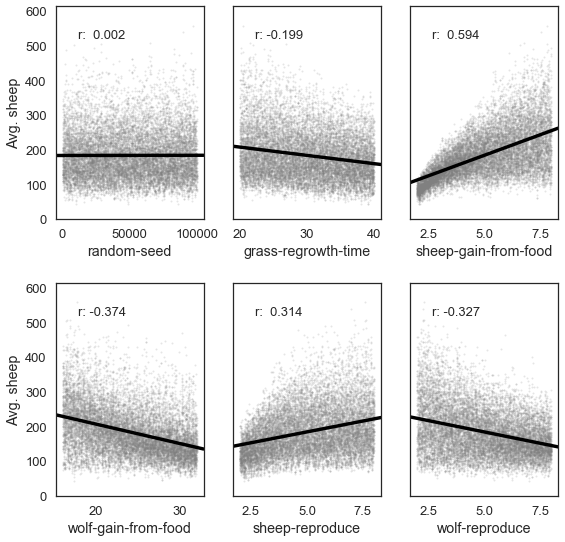

In [9]:
import scipy

nrow=2
ncol=3

fig, ax = plt.subplots(nrow, ncol, sharey=True)

y = results['Avg. sheep']

for i, a in enumerate(ax.flatten()):
    x = param_values[:,i]
    sns.regplot(x, y, ax=a, ci=None, color='k',scatter_kws={'alpha':0.2, 's':4, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
    if divmod(i,ncol)[1]>0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(problem['names'][i])
    a.set_ylim([0,1.1*np.max(y)])

fig.set_size_inches(9,9,forward=True) 
fig.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

This indicates a positive relationship between the "sheep-gain-from-food" parameter and the mean sheep count, and negative relationships for the "wolf-gain-from-food" and "wolf-reproduce" parameters.

We can then use SALib to calculate first-order (S1), second-order (S2) and total (ST) Sobol indices, to estimate each input's contribution to output variance as well as input interactions (again using the mean sheep count). By default, 95% confidence intervals are estimated for each index.

In [6]:
Si = sobol.analyze(problem, results['Avg. sheep'].values, calc_second_order=True, print_to_console=False)

As a simple example, we first select and visualize the total and first-order indices for each input, converting the dictionary returned by SALib to a DataFrame. The default pandas plotting method is then used to plot these indices along with their estimated confidence intervals (shown as error bars).

In [7]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

In [13]:
Si_df

,S1,S1_conf,ST,ST_conf
random-seed,0.047530,0.059873,0.057656,0.008165
grass-regrowth-time,0.044884,0.070364,0.099517,0.013105
sheep-gain-from-food,0.381961,0.180561,0.564394,0.065388
wolf-gain-from-food,0.163731,0.110766,0.233807,0.030697
sheep-reproduce,0.112766,0.120720,0.244354,0.037166
wolf-reproduce,0.126855,0.128140,0.232260,0.040492


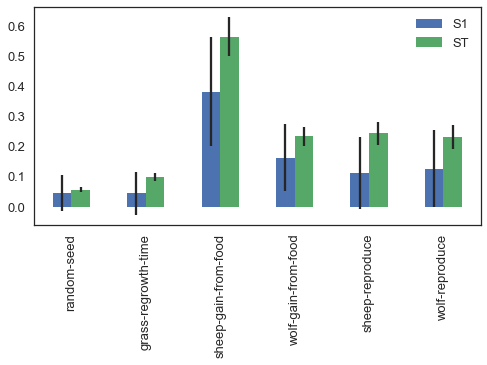

In [15]:
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()

The "sheep-gain-from-food" parameter has the highest ST index, indicating that it contributes over 50% of output variance when accounting for interactions with other parameters. However, it can be noted that confidence bounds are still quite broad with this sample size, particularly for the S1 index (which indicates each input's individual contribution to variance).

We can use a more sophisticated visualization to include the second-order interactions between inputs estimated from the S2 values.

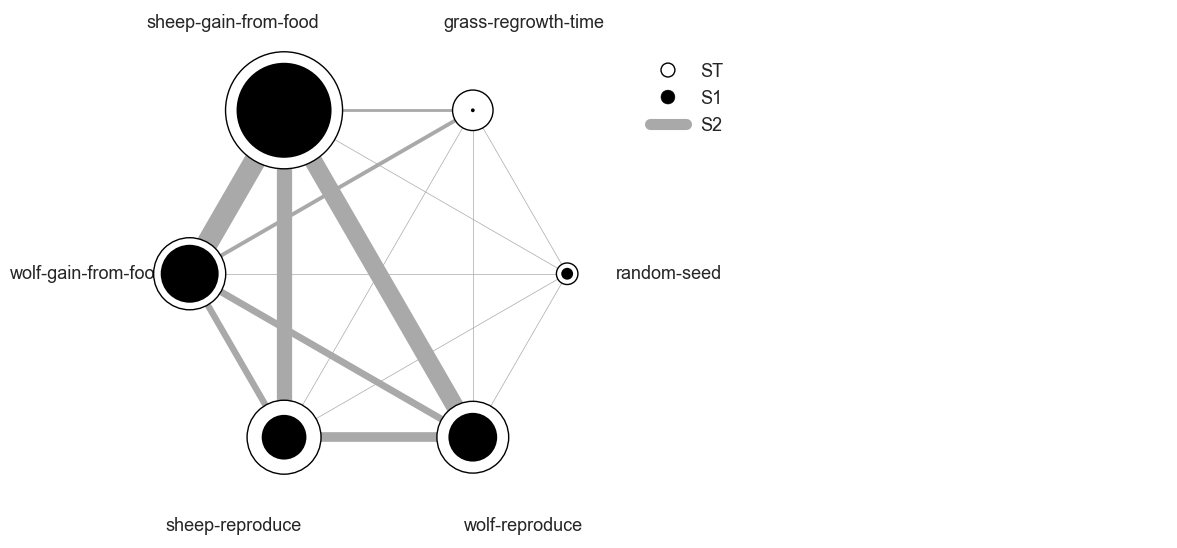

In [9]:
%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw, 
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))
    
    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'
            
        x = np.cos(loc)
        y = np.sin(loc)
        
        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)
        

def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans
        
        filtered = ([(name, locs[i]) for i, name in enumerate(names) if 
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot
    
    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff
             
    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3
    
    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}
    
    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()
 
    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'], 
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)
    
    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(ymax=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius, 
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius, 
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.ix[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
#plt.savefig('JASSS figures/Figure 8 - Interactions.pdf', bbox_inches='tight')
#plt.savefig('JASSS figures/Figure 8 - Interactions.png', dpi=300, bbox_inches='tight')
plt.show()

In this case, the "sheep-gain-from-food" variable has strong interactions with the "wolf-gain-from-food" and "wolf-reproduce" inputs in particular. The size of the ST and S1 circles correspond to the normalized variable importances.

Finally, the kill_workspace() function shuts down the NetLogo instance.

In [ ]:
netlogo.kill_workspace()